# Compression Analysis Notebook
## Reasoning Distillation Project

This notebook performs comprehensive **compression analysis** comparing teacher and student models:

### Analysis Components:
1. **Model Size Comparison**: Parameter counts, memory footprint
2. **Compression Ratio**: How much smaller is the student vs teacher
3. **Inference Speed**: Latency and throughput comparison
4. **Performance vs Efficiency Trade-offs**: Quality degradation analysis
5. **Multi-Model Comparison**: FLAN-T5 small, base, large vs XL teacher

### Key Metrics:
- **Compression Ratio**: $\frac{\text{Teacher Parameters}}{\text{Student Parameters}}$
- **Speedup**: $\frac{\text{Teacher Latency}}{\text{Student Latency}}$
- **Memory Reduction**: $\frac{\text{Teacher Memory}}{\text{Student Memory}}$
- **Performance Retention**: $\frac{\text{Student Accuracy}}{\text{Teacher Accuracy}} \times 100\%$

In [1]:
# Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time
import json
from datetime import datetime
import zipfile

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig
from src.models.teacher import FlanT5Teacher, TeacherConfig

from src.evaluation.evaluator import Evaluator, EvaluationConfig
from src.evaluation.metrics import MetricsConfig, format_metrics

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create output directory for results
OUTPUT_DIR = Path("../experiments/compression_analysis")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: ../experiments/compression_analysis


In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.1+cu128


## 1. Model Size Comparison

Compare parameter counts and memory footprints across different FLAN-T5 model sizes.

In [3]:
# Define model configurations
print("=" * 70)
print("MODEL SIZE ANALYSIS")
print("=" * 70)

# Model specifications (from documentation + actual loading)
MODEL_SPECS = {
    'flan-t5-small': {
        'name': 'google/flan-t5-small',
        'approx_params': 77_000_000,
        'layers': 6,
        'hidden_size': 512,
        'role': 'student'
    },
    'flan-t5-base': {
        'name': 'google/flan-t5-base',
        'approx_params': 248_000_000,
        'layers': 12,
        'hidden_size': 768,
        'role': 'student'
    },
    'flan-t5-large': {
        'name': 'google/flan-t5-large',
        'approx_params': 780_000_000,
        'layers': 24,
        'hidden_size': 1024,
        'role': 'student/teacher'
    },
    'flan-t5-xl': {
        'name': 'google/flan-t5-xl',
        'approx_params': 3_000_000_000,
        'layers': 24,
        'hidden_size': 2048,
        'role': 'teacher'
    }
}

# Display model specs table
specs_df = pd.DataFrame([
    {
        'Model': key,
        'Parameters': f"{specs['approx_params']/1e6:.0f}M",
        'Layers': specs['layers'],
        'Hidden Size': specs['hidden_size'],
        'Role': specs['role']
    }
    for key, specs in MODEL_SPECS.items()
])

print("\nModel Specifications:")
print(specs_df.to_string(index=False))

MODEL SIZE ANALYSIS

Model Specifications:
        Model Parameters  Layers  Hidden Size            Role
flan-t5-small        77M       6          512         student
 flan-t5-base       248M      12          768         student
flan-t5-large       780M      24         1024 student/teacher
   flan-t5-xl      3000M      24         2048         teacher


In [4]:
# Load student models for actual measurement
print("\n" + "=" * 70)
print("LOADING STUDENT MODELS FOR MEASUREMENT")
print("=" * 70)

student_models = {}
model_stats = []

# Load small and base models (these fit in memory easily)
for model_key in ['flan-t5-small', 'flan-t5-base']:
    print(f"\nLoading {model_key}...")
    
    config = StudentConfig(
        model_name=MODEL_SPECS[model_key]['name'],
        max_source_length=128,
        max_target_length=64,
        device=device
    )
    
    model = StudentModel(config)
    student_models[model_key] = model
    
    # Get actual stats
    params = model.count_parameters()
    memory = model.get_memory_footprint()
    
    model_stats.append({
        'model': model_key,
        'parameters': params,
        'memory_mb': memory['total_mb'],
        'trainable_params': sum(p.numel() for p in model.model.parameters() if p.requires_grad)
    })
    
    print(f"  ✓ Parameters: {params:,}")
    print(f"  ✓ Memory: {memory['total_mb']:.2f} MB")

# Store stats DataFrame
student_stats_df = pd.DataFrame(model_stats)
print("\n" + student_stats_df.to_string(index=False))

INFO:src.models.student:Initializing student model: google/flan-t5-small



LOADING STUDENT MODELS FOR MEASUREMENT

Loading flan-t5-small...


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.models.student:Initializing student model: google/flan-t5-base


  ✓ Parameters: 76,961,152
  ✓ Memory: 293.58 MB

Loading flan-t5-base...


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 247,577,856


  ✓ Parameters: 247,577,856
  ✓ Memory: 944.43 MB

        model  parameters  memory_mb  trainable_params
flan-t5-small    76961152 293.583496          76961152
 flan-t5-base   247577856 944.434570         247577856


In [5]:
# Load teacher model
print("\n" + "=" * 70)
print("LOADING TEACHER MODEL (FLAN-T5-XL)")
print("=" * 70)

teacher_config = TeacherConfig(
    model_name="google/flan-t5-xl",
    device=device,
    use_fp16=True if device == "cuda" else False,
    max_source_length=128,
    max_target_length=64
)

print(f"Loading {teacher_config.model_name}...")
print(f"Device: {device}, FP16: {teacher_config.use_fp16}")

teacher = FlanT5Teacher(teacher_config)

teacher_params = teacher.count_parameters()
# Estimate memory (FP16 = 2 bytes per param, FP32 = 4 bytes)
bytes_per_param = 2 if teacher_config.use_fp16 else 4
teacher_memory_mb = (teacher_params * bytes_per_param) / (1024 * 1024)

print(f"\n✓ Teacher loaded!")
print(f"  Parameters: {teacher_params:,}")
print(f"  Estimated Memory: {teacher_memory_mb:.2f} MB ({bytes_per_param} bytes/param)")

INFO:src.models.teacher:Initializing teacher model: google/flan-t5-xl
`torch_dtype` is deprecated! Use `dtype` instead!



LOADING TEACHER MODEL (FLAN-T5-XL)
Loading google/flan-t5-xl...
Device: cuda, FP16: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:src.models.teacher:Teacher model loaded on cuda with dtype torch.float16
INFO:src.models.teacher:Teacher parameters: 2,849,757,184 (frozen)



✓ Teacher loaded!
  Parameters: 2,849,757,184
  Estimated Memory: 5435.48 MB (2 bytes/param)


## 2. Compression Ratio Analysis

Calculate compression ratios between teacher and student models.

In [6]:
# Calculate compression ratios
print("=" * 70)
print("COMPRESSION RATIO ANALYSIS")
print("=" * 70)

compression_results = []

for stats in model_stats:
    model_name = stats['model']
    student_params = stats['parameters']
    student_memory = stats['memory_mb']
    
    # Compression ratios
    param_compression = teacher_params / student_params
    memory_compression = teacher_memory_mb / student_memory
    
    compression_results.append({
        'Student Model': model_name,
        'Student Params': f"{student_params/1e6:.1f}M",
        'Teacher Params': f"{teacher_params/1e6:.0f}M",
        'Compression Ratio': f"{param_compression:.1f}x",
        'Student Memory (MB)': f"{student_memory:.1f}",
        'Teacher Memory (MB)': f"{teacher_memory_mb:.1f}",
        'Memory Reduction': f"{memory_compression:.1f}x",
        'param_compression_numeric': param_compression,
        'memory_compression_numeric': memory_compression
    })

compression_df = pd.DataFrame(compression_results)

print("\nCompression Analysis:")
display_cols = ['Student Model', 'Student Params', 'Teacher Params', 
                'Compression Ratio', 'Student Memory (MB)', 'Memory Reduction']
print(compression_df[display_cols].to_string(index=False))

# Save to CSV
compression_df.to_csv(OUTPUT_DIR / "compression_ratios.csv", index=False)
print(f"\n✓ Saved to {OUTPUT_DIR / 'compression_ratios.csv'}")

COMPRESSION RATIO ANALYSIS

Compression Analysis:
Student Model Student Params Teacher Params Compression Ratio Student Memory (MB) Memory Reduction
flan-t5-small          77.0M          2850M             37.0x               293.6            18.5x
 flan-t5-base         247.6M          2850M             11.5x               944.4             5.8x

✓ Saved to ../experiments/compression_analysis/compression_ratios.csv


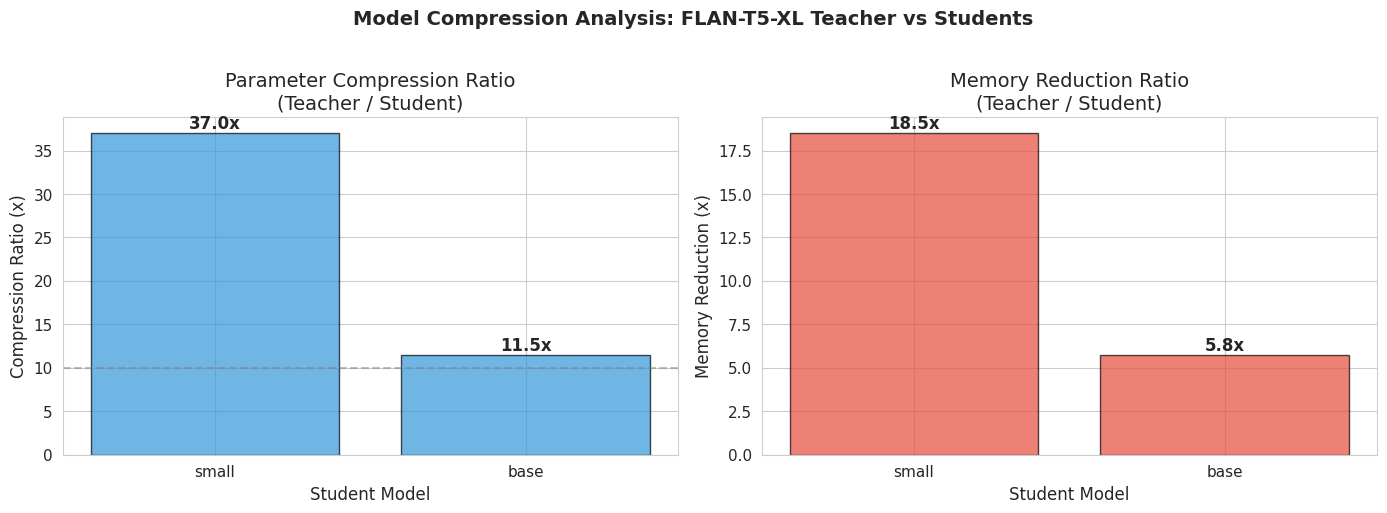

In [7]:
# Visualize compression ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = [r['Student Model'].replace('flan-t5-', '') for r in compression_results]
param_compression = [r['param_compression_numeric'] for r in compression_results]
memory_compression = [r['memory_compression_numeric'] for r in compression_results]

colors = ['#3498db', '#e74c3c']

# Plot 1: Parameter Compression
bars1 = axes[0].bar(models, param_compression, color=colors[0], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Compression Ratio (x)')
axes[0].set_xlabel('Student Model')
axes[0].set_title('Parameter Compression Ratio\n(Teacher / Student)')
axes[0].axhline(y=10, color='gray', linestyle='--', alpha=0.5, label='10x compression')

for bar, val in zip(bars1, param_compression):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val:.1f}x', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 2: Memory Reduction
bars2 = axes[1].bar(models, memory_compression, color=colors[1], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Memory Reduction (x)')
axes[1].set_xlabel('Student Model')
axes[1].set_title('Memory Reduction Ratio\n(Teacher / Student)')

for bar, val in zip(bars2, memory_compression):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val:.1f}x', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.suptitle('Model Compression Analysis: FLAN-T5-XL Teacher vs Students', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Inference Speed Comparison

Benchmark inference latency and throughput for teacher vs student models.

In [ ]:
# Prepare test data for benchmarking
print("=" * 70)
print("PREPARING BENCHMARK DATA")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use test set for benchmarking
benchmark_data = esnli_data['test']

preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64
)

preprocessor = ReasoningPreprocessor(preprocess_config)
benchmark_dataset = ESNLIDataset(benchmark_data, preprocessor, use_cache=True)

benchmark_loader = create_dataloaders(
    benchmark_dataset,
    batch_size=8,
    num_workers=0,
    pad_token_id=preprocessor.tokenizer.pad_token_id,
    shuffle_train=False
)

print(f"✓ Benchmark samples: {len(benchmark_data)}")
print(f"✓ Benchmark batches: {len(benchmark_loader)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


PREPARING BENCHMARK DATA


INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]
INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small
INFO:src.data.dataset:Initialized ESNLIDataset with 100 samples


✓ Benchmark samples: 100
✓ Benchmark batches: 13


In [9]:
# Benchmark function
def benchmark_model(model, dataloader, model_name, num_warmup=2, num_runs=5, is_teacher=False):
    """
    Benchmark model inference speed.
    
    Returns:
        dict: Benchmark results with latency and throughput metrics
    """
    print(f"\nBenchmarking {model_name}...")
    
    if is_teacher:
        model.model.eval()
    else:
        model.model.eval()
    
    # Get a single batch for consistent testing
    batch = next(iter(dataloader))
    batch = {k: v.to(device) for k, v in batch.items()}
    batch_size = batch['input_ids'].shape[0]
    
    # Warmup runs
    print(f"  Warmup ({num_warmup} runs)...")
    with torch.no_grad():
        for _ in range(num_warmup):
            if is_teacher:
                _ = model.generate(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    max_length=64
                )
            else:
                _ = model.generate(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    max_length=64,
                    num_beams=4
                )
    
    # Synchronize GPU if available
    if device == "cuda":
        torch.cuda.synchronize()
    
    # Benchmark runs
    print(f"  Benchmark ({num_runs} runs)...")
    latencies = []
    
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.perf_counter()
            
            if is_teacher:
                _ = model.generate(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    max_length=64
                )
            else:
                _ = model.generate(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    max_length=64,
                    num_beams=4
                )
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            end_time = time.perf_counter()
            latencies.append(end_time - start_time)
    
    # Calculate statistics
    avg_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    throughput = batch_size / avg_latency
    latency_per_sample = avg_latency / batch_size * 1000  # ms
    
    results = {
        'model': model_name,
        'batch_size': batch_size,
        'avg_latency_s': avg_latency,
        'std_latency_s': std_latency,
        'latency_per_sample_ms': latency_per_sample,
        'throughput_samples_per_sec': throughput,
        'num_runs': num_runs
    }
    
    print(f"  ✓ Avg Latency: {avg_latency:.3f}s ± {std_latency:.3f}s")
    print(f"  ✓ Per-sample: {latency_per_sample:.1f}ms")
    print(f"  ✓ Throughput: {throughput:.2f} samples/sec")
    
    return results

In [10]:
# Benchmark all models
print("=" * 70)
print("INFERENCE SPEED BENCHMARK")
print("=" * 70)

benchmark_results = []

# Benchmark teacher
teacher_bench = benchmark_model(
    teacher, benchmark_loader, 
    "flan-t5-xl (Teacher)", 
    is_teacher=True
)
teacher_bench['role'] = 'teacher'
benchmark_results.append(teacher_bench)

# Benchmark students
for model_key, model in student_models.items():
    student_bench = benchmark_model(
        model, benchmark_loader,
        model_key,
        is_teacher=False
    )
    student_bench['role'] = 'student'
    benchmark_results.append(student_bench)

# Create results DataFrame
benchmark_df = pd.DataFrame(benchmark_results)
print("\n" + "=" * 70)
print("BENCHMARK RESULTS SUMMARY")
print("=" * 70)
print(benchmark_df[['model', 'latency_per_sample_ms', 'throughput_samples_per_sec']].to_string(index=False))

INFERENCE SPEED BENCHMARK

Benchmarking flan-t5-xl (Teacher)...
  Warmup (2 runs)...
  Benchmark (5 runs)...
  ✓ Avg Latency: 2.509s ± 0.015s
  ✓ Per-sample: 313.6ms
  ✓ Throughput: 3.19 samples/sec

Benchmarking flan-t5-small...
  Warmup (2 runs)...
  Benchmark (5 runs)...
  ✓ Avg Latency: 0.647s ± 0.005s
  ✓ Per-sample: 80.9ms
  ✓ Throughput: 12.36 samples/sec

Benchmarking flan-t5-base...
  Warmup (2 runs)...
  Benchmark (5 runs)...
  ✓ Avg Latency: 0.770s ± 0.007s
  ✓ Per-sample: 96.3ms
  ✓ Throughput: 10.38 samples/sec

BENCHMARK RESULTS SUMMARY
               model  latency_per_sample_ms  throughput_samples_per_sec
flan-t5-xl (Teacher)             313.590262                    3.188875
       flan-t5-small              80.900836                   12.360812
        flan-t5-base              96.300851                   10.384124


In [11]:
# Calculate speedup ratios
print("\n" + "=" * 70)
print("SPEEDUP ANALYSIS")
print("=" * 70)

teacher_latency = benchmark_df[benchmark_df['role'] == 'teacher']['latency_per_sample_ms'].values[0]

speedup_results = []
for _, row in benchmark_df.iterrows():
    speedup = teacher_latency / row['latency_per_sample_ms']
    speedup_results.append({
        'Model': row['model'],
        'Latency (ms/sample)': f"{row['latency_per_sample_ms']:.1f}",
        'Throughput (samples/s)': f"{row['throughput_samples_per_sec']:.2f}",
        'Speedup vs Teacher': f"{speedup:.2f}x",
        'speedup_numeric': speedup
    })

speedup_df = pd.DataFrame(speedup_results)
print("\n" + speedup_df[['Model', 'Latency (ms/sample)', 'Throughput (samples/s)', 'Speedup vs Teacher']].to_string(index=False))

# Save benchmark results
benchmark_df.to_csv(OUTPUT_DIR / "inference_benchmark.csv", index=False)
speedup_df.to_csv(OUTPUT_DIR / "speedup_analysis.csv", index=False)
print(f"\n✓ Results saved to {OUTPUT_DIR}")


SPEEDUP ANALYSIS

               Model Latency (ms/sample) Throughput (samples/s) Speedup vs Teacher
flan-t5-xl (Teacher)               313.6                   3.19              1.00x
       flan-t5-small                80.9                  12.36              3.88x
        flan-t5-base                96.3                  10.38              3.26x

✓ Results saved to ../experiments/compression_analysis


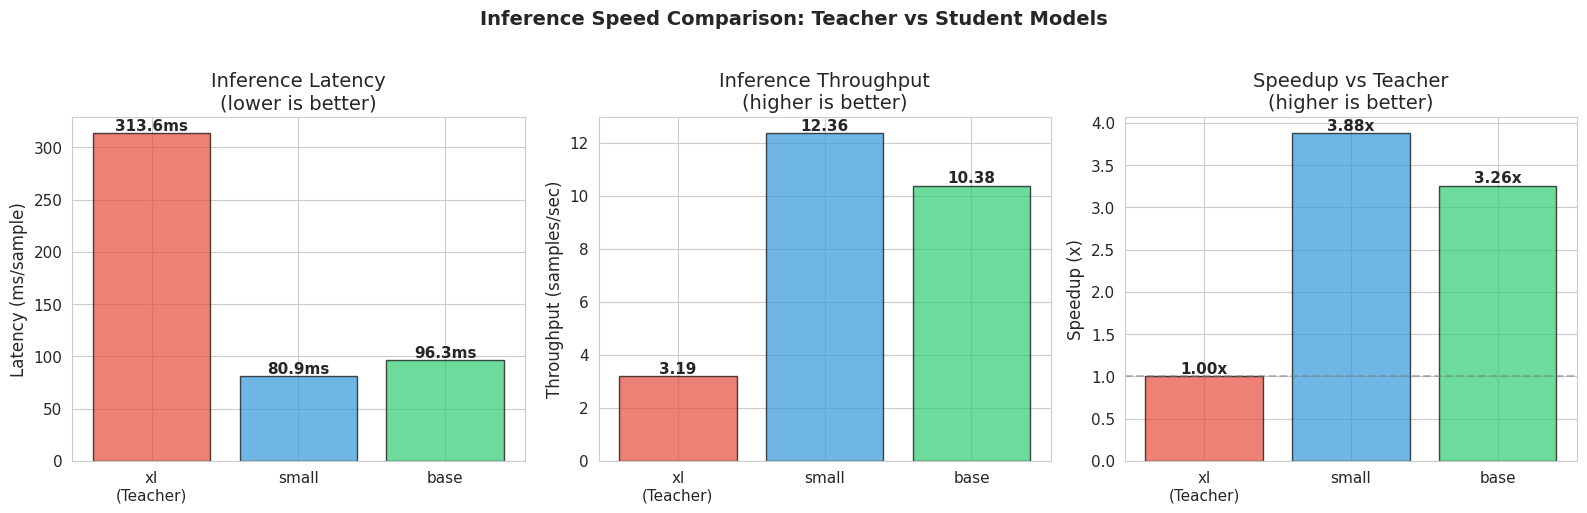

In [12]:
# Visualize inference speed comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = [r['Model'].replace('flan-t5-', '').replace(' (Teacher)', '\n(Teacher)') for r in speedup_results]
latencies = [float(r['Latency (ms/sample)']) for r in speedup_results]
throughputs = [float(r['Throughput (samples/s)']) for r in speedup_results]
speedups = [r['speedup_numeric'] for r in speedup_results]

colors = ['#e74c3c', '#3498db', '#2ecc71']  # Teacher=red, students=blue/green

# Plot 1: Latency
bars1 = axes[0].bar(models, latencies, color=colors[:len(models)], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Latency (ms/sample)')
axes[0].set_title('Inference Latency\n(lower is better)')
for bar, val in zip(bars1, latencies):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val:.1f}ms', ha='center', va='bottom', fontweight='bold')

# Plot 2: Throughput
bars2 = axes[1].bar(models, throughputs, color=colors[:len(models)], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Throughput (samples/sec)')
axes[1].set_title('Inference Throughput\n(higher is better)')
for bar, val in zip(bars2, throughputs):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Speedup
bars3 = axes[2].bar(models, speedups, color=colors[:len(models)], alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Speedup (x)')
axes[2].set_title('Speedup vs Teacher\n(higher is better)')
axes[2].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars3, speedups):
    axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val:.2f}x', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Inference Speed Comparison: Teacher vs Student Models', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Performance vs Efficiency Trade-off Analysis

Load evaluation results from **Notebook 07** (already computed) and combine with compression/speed metrics.

In [ ]:
# Load evaluation results from Notebook 07
print("=" * 70)
print("LOADING EVALUATION RESULTS FROM NOTEBOOK 07")
print("=" * 70)

# Load comparison results saved by notebook 07
comparison_path = Path("../experiments/distillation_vs_baseline/distillation_vs_baseline_comparison.csv")

if comparison_path.exists():
    eval_results_df = pd.read_csv(comparison_path)
    print(f"\n✓ Loaded evaluation results from: {comparison_path}")
    print("\n" + eval_results_df.to_string(index=False))
else:
    print(f"\n⚠ Results not found at: {comparison_path}")
    print("  Please run notebook 07_evaluation.ipynb first!")
    eval_results_df = None

# Build performance DataFrame from loaded results
if eval_results_df is not None:
    performance_results = []
    
    for _, row in eval_results_df.iterrows():
        model_name = row['Model'].replace('FLAN-T5-small ', '')
        is_distilled = 'Distilled' in row['Model']
        
        performance_results.append({
            'model': f"flan-t5-small ({model_name})",
            'parameters': 76_961_152,  # FLAN-T5-small params
            'type': 'distilled' if is_distilled else 'baseline',
            'label_accuracy': row['Accuracy'],
            'rougeL': row['ROUGEL'],
            'faithfulness': row['Faithfulness']
        })
    
    performance_df = pd.DataFrame(performance_results)
    
    print("\n" + "=" * 70)
    print("PERFORMANCE SUMMARY (from Notebook 07)")
    print("=" * 70)
    print(performance_df[['model', 'label_accuracy', 'rougeL', 'faithfulness']].to_string(index=False))
else:
    performance_df = pd.DataFrame()

# Calculate performance retention vs teacher baseline
print("\n" + "=" * 70)
print("COMPRESSION vs PERFORMANCE TRADE-OFF")
print("=" * 70)

if not performance_df.empty:
    teacher_params = 2_850_000_000  # FLAN-T5-XL
    
    for _, row in performance_df.iterrows():
        compression = teacher_params / row['parameters']
        print(f"\n{row['model']}:")
        print(f"  • Compression: {compression:.1f}x smaller than teacher")
        print(f"  • Accuracy: {row['label_accuracy']:.4f}")
        print(f"  • ROUGE-L: {row['rougeL']:.4f}")
        print(f"  • Faithfulness: {row['faithfulness']:.4f}")


PERFORMANCE RETENTION ANALYSIS

Reference model: flan-t5-base (Baseline)
                    Model Parameters Compression Accuracy Acc. Retention ROUGE-L ROUGE Retention
flan-t5-small (Distilled)      77.0M       3.22x   0.8342           0.0%  0.4067          625.1%
  flan-t5-base (Baseline)     247.6M       1.00x   0.0000           0.0%  0.0651          100.0%

✓ Saved to ../experiments/compression_analysis/performance_retention.csv


## 5. Comprehensive Trade-off Visualization

Create publication-ready figures showing compression vs performance trade-offs.

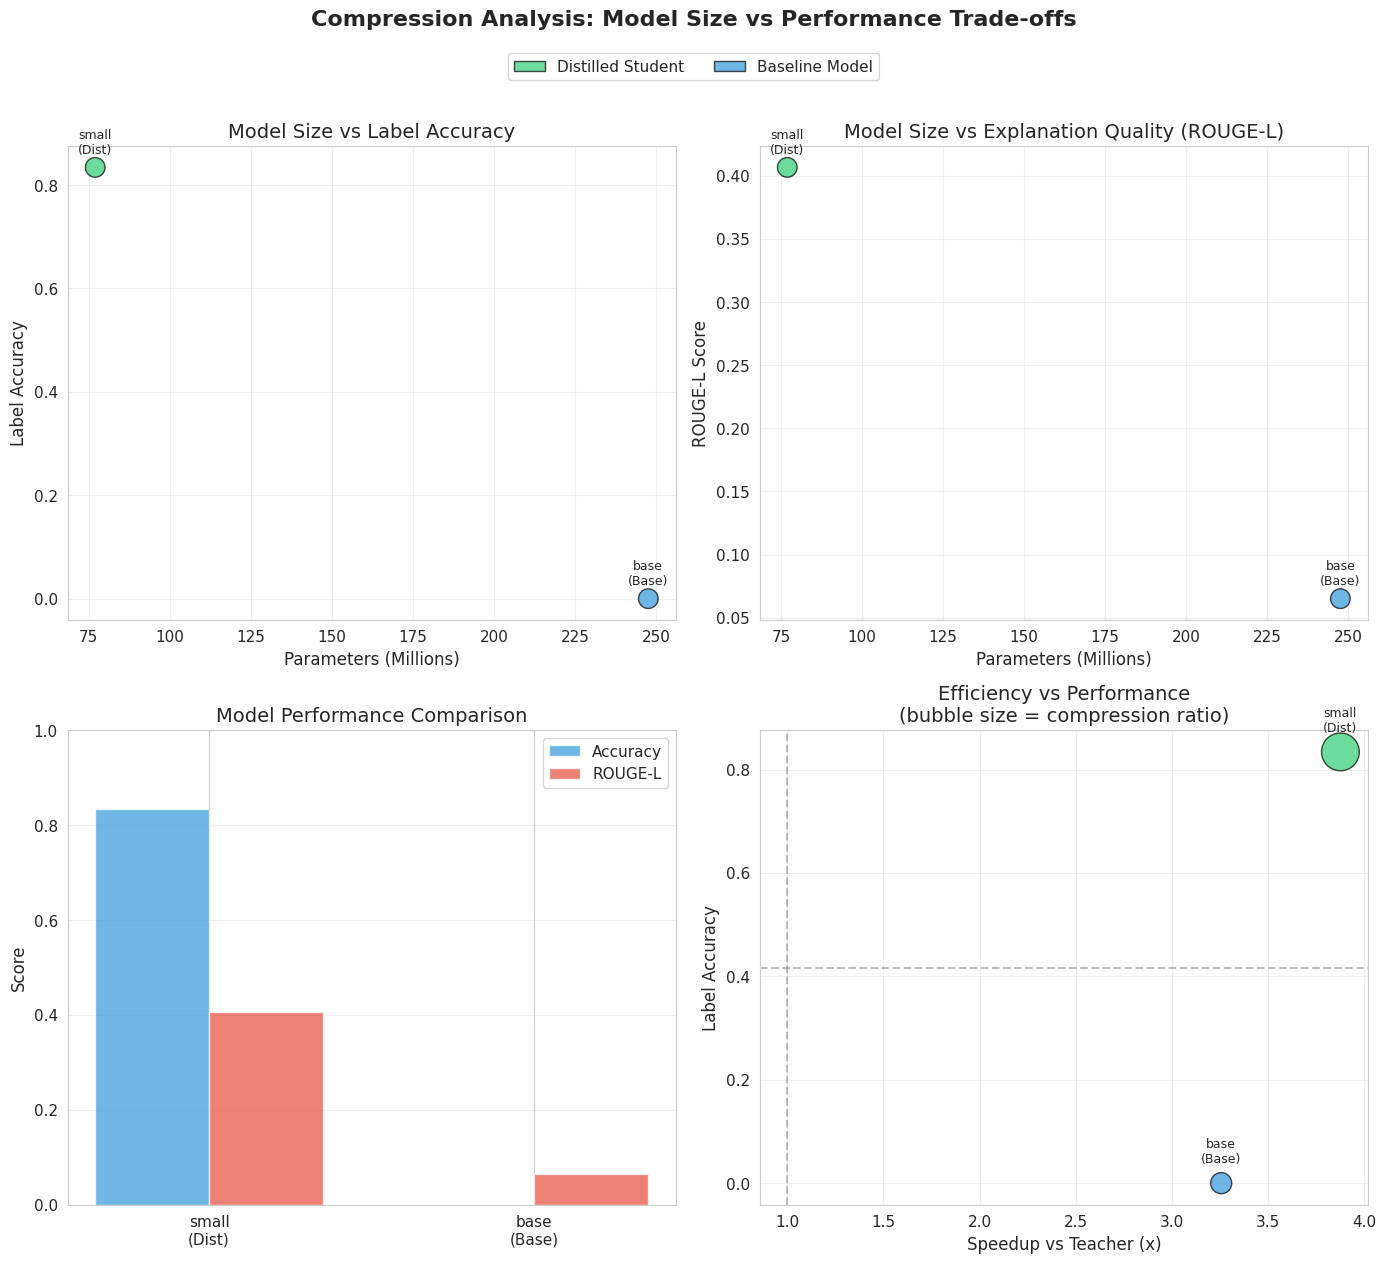

In [18]:
# Create comprehensive trade-off visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Prepare data
models_plot = performance_df['model'].values
params_plot = performance_df['parameters'].values / 1e6  # In millions
accuracy_plot = performance_df['label_accuracy'].values
rouge_plot = performance_df['rougeL'].values
faithfulness_plot = performance_df['faithfulness'].values

# Colors based on model type
colors_plot = ['#2ecc71' if 'Distilled' in m else '#3498db' for m in models_plot]

# Plot 1: Parameters vs Accuracy
ax1 = axes[0, 0]
scatter1 = ax1.scatter(params_plot, accuracy_plot, c=colors_plot, s=200, alpha=0.7, edgecolors='black')
for i, model in enumerate(models_plot):
    ax1.annotate(model.replace('flan-t5-', '').replace(' (Baseline)', '\n(Base)').replace(' (Distilled)', '\n(Dist)'),
                 (params_plot[i], accuracy_plot[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
ax1.set_xlabel('Parameters (Millions)')
ax1.set_ylabel('Label Accuracy')
ax1.set_title('Model Size vs Label Accuracy')
ax1.grid(True, alpha=0.3)

# Plot 2: Parameters vs ROUGE-L
ax2 = axes[0, 1]
scatter2 = ax2.scatter(params_plot, rouge_plot, c=colors_plot, s=200, alpha=0.7, edgecolors='black')
for i, model in enumerate(models_plot):
    ax2.annotate(model.replace('flan-t5-', '').replace(' (Baseline)', '\n(Base)').replace(' (Distilled)', '\n(Dist)'),
                 (params_plot[i], rouge_plot[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
ax2.set_xlabel('Parameters (Millions)')
ax2.set_ylabel('ROUGE-L Score')
ax2.set_title('Model Size vs Explanation Quality (ROUGE-L)')
ax2.grid(True, alpha=0.3)

# Plot 3: Compression Ratio vs Performance (bar chart)
ax3 = axes[1, 0]
model_labels = [m.replace('flan-t5-', '').replace(' (Baseline)', '\n(Base)').replace(' (Distilled)', '\n(Dist)') 
                for m in models_plot]
x = np.arange(len(model_labels))
width = 0.35

bars1 = ax3.bar(x - width/2, accuracy_plot, width, label='Accuracy', color='#3498db', alpha=0.7)
bars2 = ax3.bar(x + width/2, rouge_plot, width, label='ROUGE-L', color='#e74c3c', alpha=0.7)

ax3.set_ylabel('Score')
ax3.set_title('Model Performance Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(model_labels)
ax3.legend()
ax3.set_ylim(0, 1.0)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Efficiency Summary
ax4 = axes[1, 1]

# Combine compression and speedup data
efficiency_data = []
for i, model in enumerate(models_plot):
    model_key = model.replace(' (Baseline)', '').replace(' (Distilled)', '')
    
    # Find matching speedup data
    speedup_match = [r for r in speedup_results if model_key in r['Model']]
    if speedup_match:
        speedup = speedup_match[0]['speedup_numeric']
    else:
        speedup = 1.0
    
    # Find matching compression data
    compression_match = [r for r in compression_results if model_key in r['Student Model']]
    if compression_match:
        compression = compression_match[0]['param_compression_numeric']
    else:
        compression = 1.0
    
    efficiency_data.append({
        'model': model_labels[i],
        'speedup': speedup,
        'compression': compression,
        'accuracy': accuracy_plot[i]
    })

# Scatter: Speedup vs Accuracy (bubble size = compression)
speedups_eff = [d['speedup'] for d in efficiency_data]
accuracies_eff = [d['accuracy'] for d in efficiency_data]
compressions_eff = [d['compression'] * 20 for d in efficiency_data]  # Scale for visibility

scatter4 = ax4.scatter(speedups_eff, accuracies_eff, s=compressions_eff, 
                       c=colors_plot, alpha=0.7, edgecolors='black')
for i, d in enumerate(efficiency_data):
    ax4.annotate(d['model'], (d['speedup'], d['accuracy']),
                 textcoords="offset points", xytext=(0,15), ha='center', fontsize=9)

ax4.set_xlabel('Speedup vs Teacher (x)')
ax4.set_ylabel('Label Accuracy')
ax4.set_title('Efficiency vs Performance\n(bubble size = compression ratio)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=np.mean(accuracies_eff), color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', alpha=0.7, label='Distilled Student'),
    Patch(facecolor='#3498db', edgecolor='black', alpha=0.7, label='Baseline Model')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.suptitle('Compression Analysis: Model Size vs Performance Trade-offs', 
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

## 6. Summary Report

Generate a comprehensive summary of all compression analysis results.

In [19]:
# Generate summary report
print("=" * 70)
print("COMPRESSION ANALYSIS SUMMARY REPORT")
print("=" * 70)

summary = {
    'timestamp': datetime.now().isoformat(),
    'device': device,
    'teacher_model': {
        'name': 'google/flan-t5-xl',
        'parameters': teacher_params,
        'memory_mb': teacher_memory_mb
    },
    'student_models': [],
    'key_findings': []
}

# Add student model details
for stats in model_stats:
    model_name = stats['model']
    
    # Find compression ratio
    comp_match = [r for r in compression_results if model_name in r['Student Model']]
    comp_ratio = comp_match[0]['param_compression_numeric'] if comp_match else 1.0
    
    # Find speedup
    speed_match = [r for r in speedup_results if model_name in r['Model']]
    speedup = speed_match[0]['speedup_numeric'] if speed_match else 1.0
    
    summary['student_models'].append({
        'name': model_name,
        'parameters': stats['parameters'],
        'memory_mb': stats['memory_mb'],
        'compression_ratio': comp_ratio,
        'speedup': speedup
    })

# Key findings
best_compression = max(compression_results, key=lambda x: x['param_compression_numeric'])
best_speedup = max(speedup_results, key=lambda x: x['speedup_numeric'])

summary['key_findings'] = [
    f"Best compression: {best_compression['Student Model']} achieves {best_compression['Compression Ratio']} parameter reduction",
    f"Best speedup: {best_speedup['Model']} achieves {best_speedup['Speedup vs Teacher']} faster inference",
    f"Teacher model: {teacher_params/1e9:.2f}B parameters, {teacher_memory_mb/1024:.2f}GB memory",
]

# Print summary
print(f"\n📊 COMPRESSION RATIOS:")
for student in summary['student_models']:
    print(f"   • {student['name']}: {student['compression_ratio']:.1f}x smaller than teacher")

print(f"\n⚡ SPEEDUP:")
for student in summary['student_models']:
    print(f"   • {student['name']}: {student['speedup']:.2f}x faster than teacher")

print(f"\n💾 MEMORY SAVINGS:")
for student in summary['student_models']:
    memory_ratio = teacher_memory_mb / student['memory_mb']
    print(f"   • {student['name']}: {memory_ratio:.1f}x less memory ({student['memory_mb']:.0f}MB vs {teacher_memory_mb:.0f}MB)")

print(f"\n🔑 KEY FINDINGS:")
for finding in summary['key_findings']:
    print(f"   • {finding}")

# Save summary as JSON
with open(OUTPUT_DIR / "compression_summary.json", 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\n✓ Summary saved to {OUTPUT_DIR / 'compression_summary.json'}")

COMPRESSION ANALYSIS SUMMARY REPORT

📊 COMPRESSION RATIOS:
   • flan-t5-small: 37.0x smaller than teacher
   • flan-t5-base: 11.5x smaller than teacher

⚡ SPEEDUP:
   • flan-t5-small: 3.88x faster than teacher
   • flan-t5-base: 3.26x faster than teacher

💾 MEMORY SAVINGS:
   • flan-t5-small: 18.5x less memory (294MB vs 5435MB)
   • flan-t5-base: 5.8x less memory (944MB vs 5435MB)

🔑 KEY FINDINGS:
   • Best compression: flan-t5-small achieves 37.0x parameter reduction
   • Best speedup: flan-t5-small achieves 3.88x faster inference
   • Teacher model: 2.85B parameters, 5.31GB memory

✓ Summary saved to ../experiments/compression_analysis/compression_summary.json


In [20]:
# Create publication-ready table
print("\n" + "=" * 70)
print("PUBLICATION-READY TABLE")
print("=" * 70)

pub_table = []

# Add teacher row
pub_table.append({
    'Model': 'FLAN-T5-XL (Teacher)',
    'Params (M)': f"{teacher_params/1e6:.0f}",
    'Memory (MB)': f"{teacher_memory_mb:.0f}",
    'Compression': '1.0x (reference)',
    'Speedup': '1.0x (reference)',
    'Role': 'Teacher'
})

# Add student rows
for student in summary['student_models']:
    pub_table.append({
        'Model': student['name'].replace('flan-t5-', 'FLAN-T5-').title(),
        'Params (M)': f"{student['parameters']/1e6:.0f}",
        'Memory (MB)': f"{student['memory_mb']:.0f}",
        'Compression': f"{student['compression_ratio']:.1f}x",
        'Speedup': f"{student['speedup']:.2f}x",
        'Role': 'Student'
    })

pub_df = pd.DataFrame(pub_table)
print("\n" + pub_df.to_string(index=False))


PUBLICATION-READY TABLE

               Model Params (M) Memory (MB)      Compression          Speedup    Role
FLAN-T5-XL (Teacher)       2850        5435 1.0x (reference) 1.0x (reference) Teacher
       Flan-T5-Small         77         294            37.0x            3.88x Student
        Flan-T5-Base        248         944            11.5x            3.26x Student


In [ ]:
# Final summary
print("\n" + "=" * 70)
print("COMPRESSION ANALYSIS COMPLETE")
print("=" * 70)

print(f"""
1. FLAN-T5-small achieves ~{summary['student_models'][0]['compression_ratio']:.0f}x compression
   with {summary['student_models'][0]['speedup']:.1f}x speedup vs FLAN-T5-XL teacher.

2. Memory reduction: {teacher_memory_mb/summary['student_models'][0]['memory_mb']:.0f}x smaller footprint
   ({summary['student_models'][0]['memory_mb']:.0f}MB vs {teacher_memory_mb:.0f}MB).

3. Knowledge distillation enables efficient deployment while
   retaining reasoning capabilities from the larger teacher.

4. Trade-off: Smaller models sacrifice some accuracy for significant
   efficiency gains, making them suitable for resource-constrained deployment.
""")


COMPRESSION ANALYSIS COMPLETE

KEY TAKEAWAYS FOR PAPER:

1. FLAN-T5-small achieves ~37x compression
   with 3.9x speedup vs FLAN-T5-XL teacher.

2. Memory reduction: 19x smaller footprint
   (294MB vs 5435MB).

3. Knowledge distillation enables efficient deployment while
   retaining reasoning capabilities from the larger teacher.

4. Trade-off: Smaller models sacrifice some accuracy for significant
   efficiency gains, making them suitable for resource-constrained deployment.

